In [ ]:
!pip install tensorflow

#Step 1 : Prepare input data by adding noise to CIFAR10 Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, Conv2DTranspose, Activation, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint,Callback,LearningRateScheduler
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import regularizers
import tensorflow as tf


Load the CIFAR10 dataset having shape of [32, 32, 3]. Rescale data to [0, 1] by dividing with 255.

## Adding noice

To add noise we can generate array with same dimension of our images with random values between `[0,1]` using normal distribution with mean = 0 and standard deviation = 0.3.

To generate normal distribution, we can use `np.random.normal(loc,scale,size)`. Then scale the noise by some factor, here I am using `0.3`. After adding noise, pixel values can be out of range `[0,1]`, so we need to clip the values using `np.clip(arr, arr_min, arr_max )`.

In [ ]:
from tensorflow.keras.datasets import cifar10

# Load the dataset correctly
(train_data_clean, _), (test_data_clean, _) = cifar10.load_data()

# Scaling input data
train_data_clean = train_data_clean.astype('float32') / 255.
test_data_clean = test_data_clean.astype('float32') / 255.


def add_noise_and_clip(data):
  noise = np.random.normal(loc=0.0, scale=0.3, size=data.shape)
  data= data+ noise * 0.3
  data = np.clip(data, 0., 1.)
  return data

train_data_noisy = add_noise_and_clip(train_data_clean)
test_data_noisy = add_noise_and_clip(test_data_clean)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


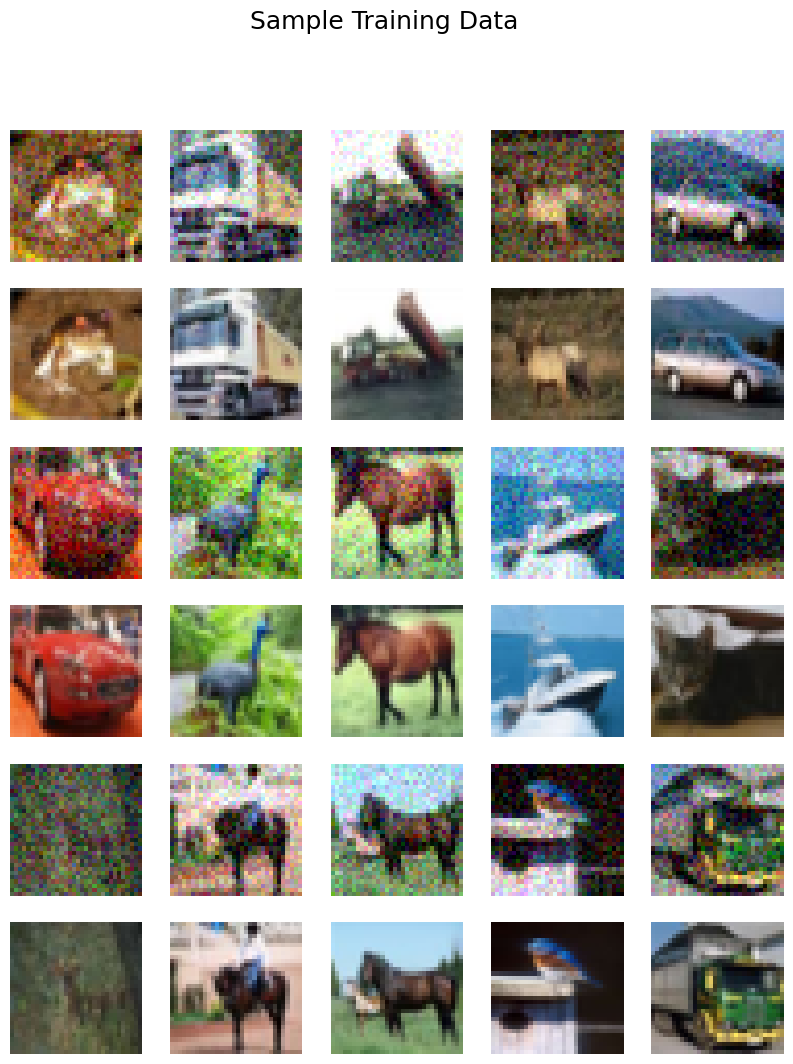

In [ ]:
rows=3 #defining no.of rows in figure
cols=5 # defining no. of columns in figure

f = plt.figure(figsize=(2 * cols ,2*rows*2)) #defining a figure

for i in range(rows):
  for j in range(cols):
    f.add_subplot(rows*2,cols,(2*i*cols)+(j+1)) # adding sub plot to figure on each iteration
    plt.imshow(train_data_noisy[i*cols+j])
    plt.axis("off")

  for j in range(cols):
    f.add_subplot(rows*2,cols,((2*i+1)*cols)+(j+1))#adding sub plot to figure on each iteration
    plt.imshow(train_data_clean[i*cols+j])
    plt.axis("off")
f.suptitle("Sample Training Data",fontsize=18)
plt.savefig("Cifar-train.png")

plt.show()


#Step 2: Build a CNN Autoencoder Network
##Architecture
Convolutional blocks consist of 3 operations: 2D convolution, batch normalization and ReLu activation. We use strides=2 to downsample data going through the network.

Deconvolutional blocks also consist of 3 operations: 2D transposed convolution, batch normalization and also ReLu activation. Here strides=2 is used to upsample the data.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input

def conv_block(x, filters, kernel_size, strides=2):  # Fixed 'kernal_size' -> 'kernel_size'
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,  # Fixed typo
               strides=strides,
               padding='same',
               activation='relu',
               kernel_regularizer=regularizers.l2(0.001))(x)
    x= BatchNormalization()(x)
    return x
def deconv_block(x,filters,kernel_size):
  x= Conv2DTranspose(filters=filters,
                     kernel_size=kernel_size,
                      strides=2,
                      padding='same',
                      activation='relu',
                      kernel_regularizer=regularizers.l2(0.001))(x)
  x = BatchNormalization()(x)
  return x

- 5 convolutional blocks with downsampling
- 1 convolutional block without downsampling
- 5 deconvolutional blocks with upsampling, interleaving concatenations
- 1 final deconvolution that recreates image size (32, 32, 3)
- 1 activation layer with sigmoid that scales values to 0-1.

In [ ]:
def autoencoder():
  inputs= Input(shape=(32,32,3),name='inputs')
  conv_block1= conv_block(inputs,32,3)
  conv_block2= conv_block(conv_block1,64,3)
  conv_block3= conv_block(conv_block2,128,3)
  conv_block4= conv_block(conv_block3,256,3)
  conv_block5= conv_block(conv_block4,256,3)
  conv_block6= conv_block(conv_block5,512,3,1)

  deconv_block1= deconv_block(conv_block6,512,3)
  merge1= Concatenate()([deconv_block1,conv_block4])
  deconv_block2= deconv_block(merge1,256,3)
  merge2= Concatenate()([deconv_block2,conv_block3])
  deconv_block3= deconv_block(merge2,128,3)
  merge3= Concatenate()([deconv_block3,conv_block2])
  deconv_block4= deconv_block(merge3,64,3)
  merge4= Concatenate()([deconv_block4,conv_block1])
  deconv_block5= deconv_block(merge4,32,3)

  final_deconv= Conv2DTranspose(filters=3,
                                kernel_size=3,
                                padding='same')(deconv_block5)
  outputs=Activation('sigmoid',name='output')(final_deconv)
  return Model(inputs,outputs,name='autoencoder')

In [ ]:
model=autoencoder()

def scheduler(epoch):
  if epoch<10:
     return 0.0001
  else:
    return 0.00001*tf.math.exp(0.1*(10-epoch))
class myCallback(Callback):
   def on_epoch_end(self,epoch,logs={}):
       if(logs.get('accuracy')>0.80):
         print("\nReached 80% accuracy so cancelling training!")
         self.model.stop_training=True
callbacks=myCallback()

lr=LearningRateScheduler(scheduler)
checkpoint=ModelCheckpoint('model.h5',verbose=1,save_best_only=True,save_weights_only=False)

model.compile(optimizer='adam',loss='mse',metrics=["accuracy"])
model.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)       │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 16, 16, 32)     │            896 │ inputs[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 16, 16, 32)     │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 8, 8, 64)       │         18,496 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 8, 8, 64)       │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 4, 4, 128)      │         73,856 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 4, 4, 128)      │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 2, 2, 256)      │        295,168 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 2, 2, 256)      │          1,024 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 1, 1, 256)      │        590,080 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 1, 1, 256)      │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 1, 1, 512)      │      1,180,160 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 1, 1, 512)      │          2,048 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 2, 2, 512)      │      2,359,808 │ batch_normalization_5… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 2, 2, 512)      │          2,048 │ conv2d_transpose[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concaten

 Total params: 6,878,851 (26.24 MB)

 Trainable params: 6,874,371 (26.22 MB)

 Non-trainable params: 4,480 (17.50 KB)

In [ ]:
#Training
history = model.fit(train_data_noisy,
                    train_data_clean,
                    validation_data=(test_data_noisy, test_data_clean),
                    epochs=3,
                    batch_size=128,
                    shuffle=True,
                    callbacks=[callbacks,checkpoint,lr])

Epoch 1/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4613 - loss: 1.1734
Epoch 1: val_loss improved from inf to 0.10355, saving model to model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 1264s 3s/step - accuracy: 0.4615 - loss: 1.1720 - val_accuracy: 0.6323 - val_loss: 0.1036 - learning_rate: 1.0000e-04
Epoch 2/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6869 - loss: 0.0602
Epoch 2: val_loss improved from 0.10355 to 0.02042, saving model to model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 1187s 3s/step - accuracy: 0.6869 - loss: 0.0602 - val_accuracy: 0.7146 - val_loss: 0.0204 - learning_rate: 1.0000e-04
Epoch 3/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7392 - loss: 0.0151
Epoch 3: val_loss improved from 0.02042 to 0.00884, saving model to model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 1134s 3s/step - accuracy: 0.7392 - loss: 0.0151 - val_accuracy: 0.7358 - val_loss: 0.0088 - learning_rate: 1.0000e-04


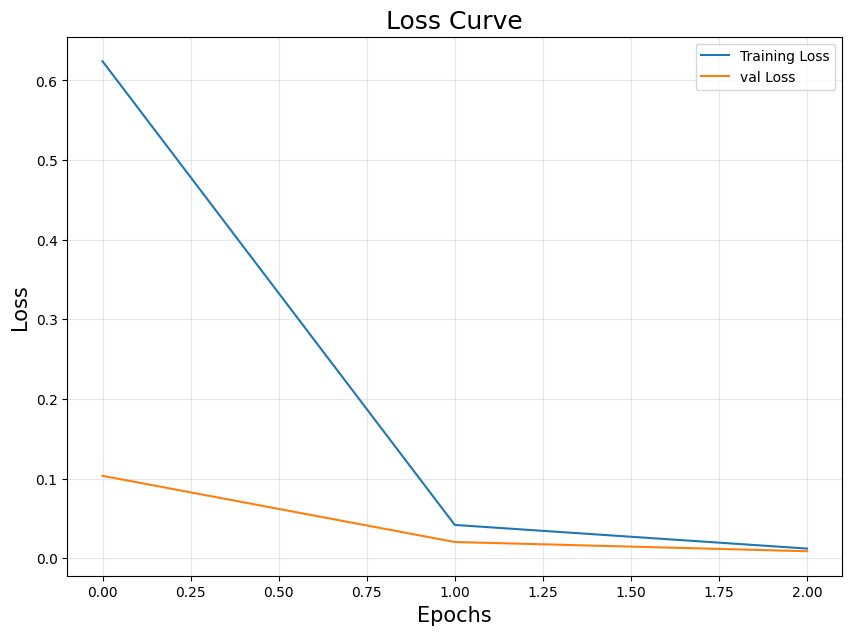

In [ ]:
#Defining Figure
f=plt.figure(figsize=(10,7))
f.add_subplot()

#Adding Subplot
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='val Loss')
plt.title('Loss Curve',fontsize=18)
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("Loss_Curve_cifar10.png")
plt.show()

#Step 4: Test the performance of Autoencoder


In [ ]:
#Select few random images
num_imgs=48
rand=np.random.randint(1,test_data_noisy.shape[0]-48)
cifar_test_images=test_data_noisy[rand:rand+num_imgs]
cifar_test_predicted=model.predict(cifar_test_images)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 834ms/step


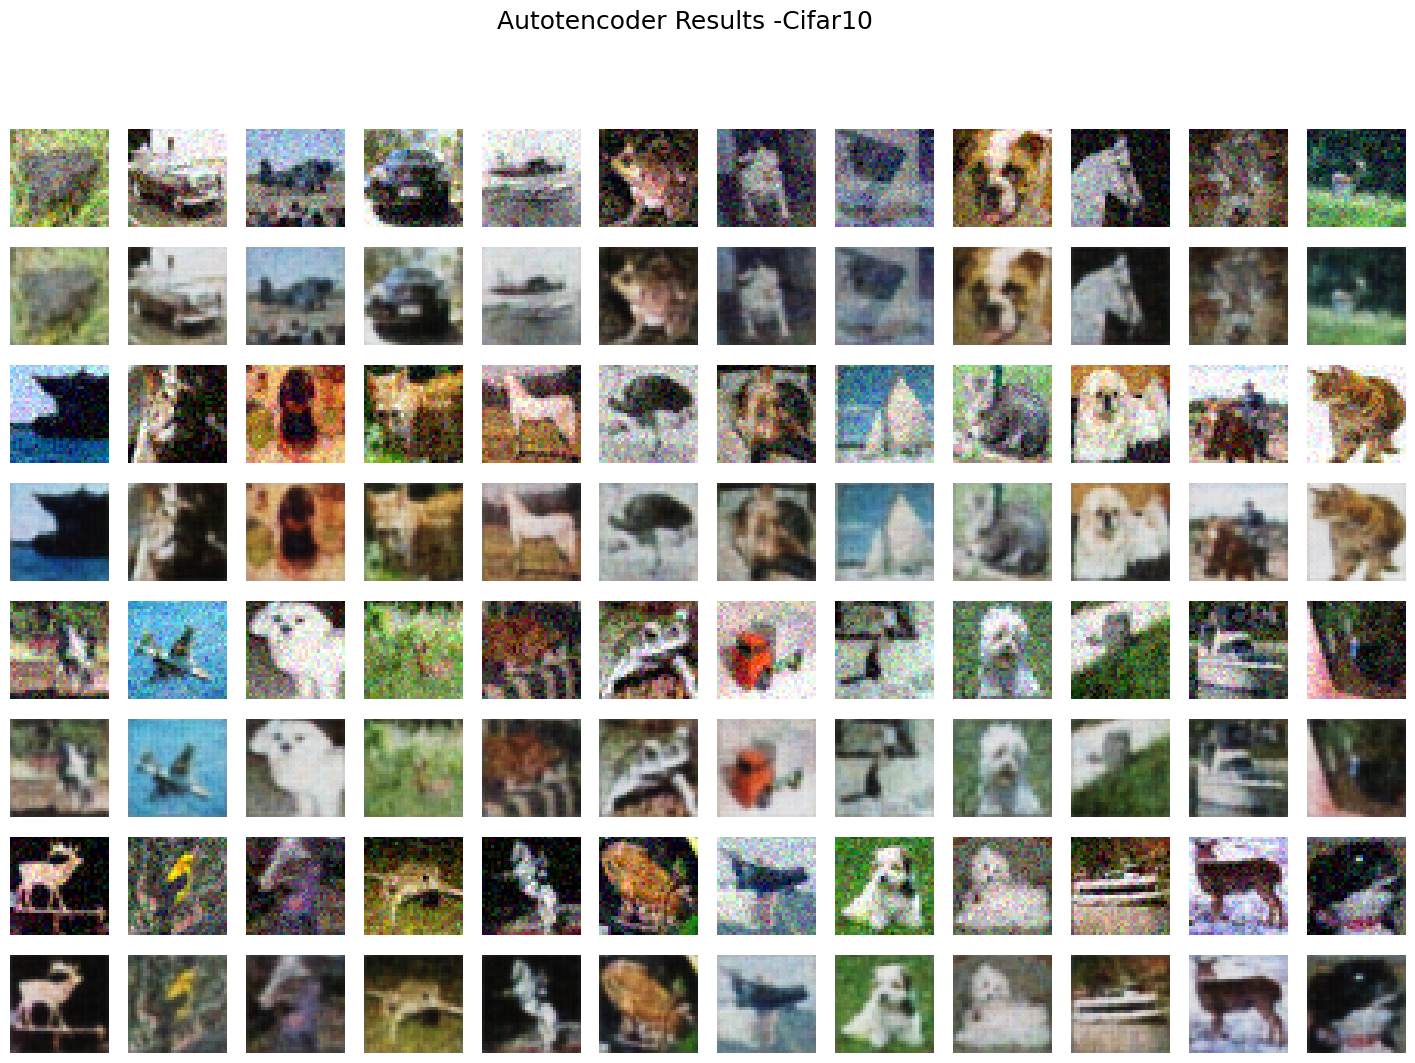

In [ ]:
rows=4
cols=12
cell_size=1.5
f=plt.figure(figsize=(cell_size*cols,cell_size*rows*2))
f.tight_layout()
for i in range(rows):
  for j in range(cols):
    f.add_subplot(rows*2,cols,(2*i*cols)+(j+1))
    plt.imshow(cifar_test_images[i*cols+j])
    plt.axis('off')

  for j in range(cols):
    f.add_subplot(rows*2,cols,((2*i+1)*cols)+(j+1))
    plt.imshow(cifar_test_predicted[i*cols+j])
    plt.axis('off')

f.suptitle("Autotencoder Results -Cifar10",fontsize=18)
plt.savefig("Autoencoder_cifar10.png")
plt.show()

#Image classifier

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

Load the datset

In [2]:
(X_train, y_train), (X_test,y_test) = datasets.cifar10.load_data()
X_train.shape

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


(50000, 32, 32, 3)

In [3]:
X_test.shape

(10000, 32, 32, 3)

Here we see there are 50000 training images and 1000 test images

In [4]:
y_train.shape


(50000, 1)

In [5]:
y_train[:5]

array([[6],
       [9],
       [9],
       [4],
       [1]], dtype=uint8)

In [6]:
y_train = y_train.reshape(-1,)
y_train[:5]


array([6, 9, 9, 4, 1], dtype=uint8)

In [7]:
y_test = y_test.reshape(-1,)

In [8]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

Let's plot some images to see what they are

In [9]:
def plot_sample(X, y, index):
    plt.figure(figsize = (15,2))
    plt.imshow(X[index])
    plt.xlabel(classes[y[index]])

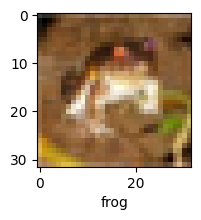

In [10]:
plot_sample(X_train, y_train, 0)

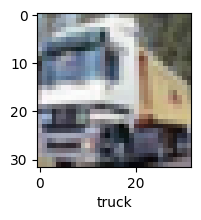

In [12]:
plot_sample(X_train, y_train, 1)


Normalize the images to a number from 0 to 1. Image has 3 channels (R,G,B) and each value in the channel can range from 0 to 255. Hence to normalize in 0-->1 range, we need to divide it by 255

#Normalizing the training data


In [13]:
X_train = X_train / 255.0
X_test = X_test / 255.0

#Build simple artificial neural network for image classification

In [14]:
ann = models.Sequential([
        layers.Flatten(input_shape=(32,32,3)),
        layers.Dense(3000, activation='relu'),
        layers.Dense(1000, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

ann.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

ann.fit(X_train, y_train, epochs=5)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 127s 81ms/step - accuracy: 0.3078 - loss: 1.9345
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 141s 80ms/step - accuracy: 0.4197 - loss: 1.6481
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 124s 79ms/step - accuracy: 0.4524 - loss: 1.5492
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 149s 84ms/step - accuracy: 0.4761 - loss: 1.4919
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 128s 82ms/step - accuracy: 0.4971 - loss: 1.4370


#You can see that at the end of 5 epochs, accuracy is at around 49%

In [15]:
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np
y_pred = ann.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report: \n", classification_report(y_test, y_pred_classes))

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.67      0.38      0.49      1000
           1       0.48      0.72      0.58      1000
           2       0.55      0.05      0.10      1000
           3       0.38      0.23      0.29      1000
           4       0.35      0.55      0.43      1000
           5       0.41      0.32      0.36      1000
           6       0.39      0.70      0.50      1000
           7       0.71      0.36      0.48      1000
           8       0.41      0.81      0.55      1000
           9       0.57      0.34      0.42      1000

    accuracy                           0.45     10000
   macro avg       0.49      0.45      0.42     10000
weighted avg       0.49      0.45      0.42     10000



#Now let us build a convolutional neural network to train our images

In [17]:
cnn = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:

cnn.fit(X_train, y_train, epochs=10)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 62s 39ms/step - accuracy: 0.3830 - loss: 1.6869
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 39ms/step - accuracy: 0.5927 - loss: 1.1627
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 39ms/step - accuracy: 0.6471 - loss: 1.0053
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 38ms/step - accuracy: 0.6802 - loss: 0.9231
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.7040 - loss: 0.8454
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 37ms/step - accuracy: 0.7328 - loss: 0.7705
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 37ms/step - accuracy: 0.7480 - loss: 0.7247
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 37ms/step - accuracy: 0.7599 - loss: 0.6902
Epoch 9/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 37ms/step - accuracy: 0.7764 - loss: 0.6498
Epoch 10/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.7854 - loss: 0.6192


#With CNN, at the end 5 epochs, accuracy was at around 70% which is a significant improvement over ANN. CNN's are best for image classification and gives superb accuracy. Also computation is much less compared to simple ANN as maxpooling reduces the image dimensions while still preserving the feature

In [20]:
cnn.evaluate(X_test,y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7072 - loss: 0.8882


[0.8906382918357849, 0.705299973487854]

In [21]:
y_pred = cnn.predict(X_test)
y_pred[:5]

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


array([[2.1356404e-04, 1.0123730e-04, 5.0180877e-04, 7.9653275e-01,
        1.3390573e-04, 1.3529551e-01, 7.6663340e-03, 2.2881704e-04,
        5.9027750e-02, 2.9830978e-04],
       [1.1582489e-03, 1.0845911e-03, 1.4621426e-06, 6.4120536e-07,
        3.6533610e-08, 1.1665485e-09, 2.0794170e-07, 1.3433531e-08,
        9.9755698e-01, 1.9776054e-04],
       [1.9921912e-01, 3.6822040e-02, 2.6421892e-03, 3.6849943e-03,
        3.3472402e-03, 2.7671372e-04, 5.3627137e-04, 3.5492883e-03,
        7.2499210e-01, 2.4929989e-02],
       [9.9305177e-01, 2.6366115e-04, 1.9470498e-03, 3.1010379e-05,
        5.4139213e-04, 9.1975136e-07, 4.8015663e-05, 9.3953959e-06,
        4.0970375e-03, 9.8495293e-06],
       [3.6145295e-06, 5.5899520e-05, 9.8131262e-02, 2.6395209e-02,
        4.6415138e-01, 6.9649736e-03, 4.0417507e-01, 2.4708555e-05,
        7.8340221e-05, 1.9452984e-05]], dtype=float32)

In [22]:
y_classes = [np.argmax(element) for element in y_pred]
y_classes[:5]

[3, 8, 8, 0, 4]

In [23]:
y_test[:5]

array([3, 8, 8, 0, 6], dtype=uint8)

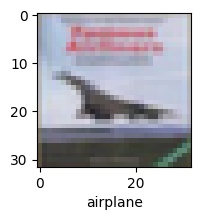

In [24]:
plot_sample(X_test, y_test,3)

In [25]:
classes[y_classes[3]]

'airplane'

In [27]:
classes[y_classes[4]]

'deer'